In [19]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain_anthropic

In [21]:
import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

In [24]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [26]:
from typing import Annotated, Union

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import ToolMessage, AIMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatAnthropic(model="claude-3-haiku-20240307")
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

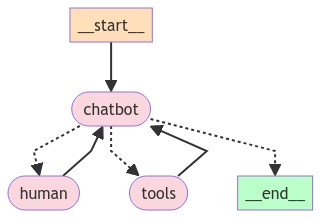

In [27]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [28]:
user_input = "I need some expert guidance for building this AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building this AI agent. Could you request assistance for me?
================================== Ai Message ==================================

[{'id': 'toolu_01XixbBRdFQPzPr9KqSdn3y5', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}]
Tool Calls:
  RequestAssistance (toolu_01XixbBRdFQPzPr9KqSdn3y5)
 Call ID: toolu_01XixbBRdFQPzPr9KqSdn3y5
  Args:
    request: I need some expert guidance for building this AI agent.


In [29]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

In [9]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Rahil. It's a pleasure to meet you!


In [33]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '1',
  'thread_ts': '1ef173a1-3e75-6a18-8002-c6de57f94dc3'}}

In [34]:
graph.get_state(config).values["messages"]

[HumanMessage(content='I need some expert guidance for building this AI agent. Could you request assistance for me?', id='afd41560-9ca7-4e29-a071-ce10a48bc479'),
 AIMessage(content=[{'id': 'toolu_01XixbBRdFQPzPr9KqSdn3y5', 'input': {'request': 'I need some expert guidance for building this AI agent.'}, 'name': 'RequestAssistance', 'type': 'tool_use'}], response_metadata={'id': 'msg_01SP2X7H2PhPXoe1vft99X19', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 486, 'output_tokens': 63}}, id='run-b0bfd3cf-23f3-4d25-8c2c-154434c5d6b3-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'I need some expert guidance for building this AI agent.'}, 'id': 'toolu_01XixbBRdFQPzPr9KqSdn3y5'}]),
 ToolMessage(content="We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.", id='7f7a7f41-7dbe-4f7a-9c9a-d8f81885a1c4', too

In [35]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

The experts have recommended checking out LangGraph to build your AI agent. LangGraph is a more reliable and extensible framework for creating AI agents compared to some autonomous approaches. Let me know if you have any other questions!


In [7]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/callbacks/manager.py", line 1997, in _configure
    handler = LangChainTracer(
              ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 91, in __init__
    self.client = client or get_client()
                            ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 54, in get_client
    _CLIENT = Client()
              ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line 534, in __init__
    _validate_api_key_if_hosted(self.api_url, self.api_key)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line

Assistant: [{'id': 'toolu_017GxJQUsne5nmuGtDnxL7cC', 'input': {'query': 'latest in indian politics'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]


--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/callbacks/manager.py", line 1997, in _configure
    handler = LangChainTracer(
              ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 91, in __init__
    self.client = client or get_client()
                            ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 54, in get_client
    _CLIENT = Client()
              ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line 534, in __init__
    _validate_api_key_if_hosted(self.api_url, self.api_key)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line

Assistant: [{"url": "https://indianexpress.com/section/political-pulse/", "content": "Among 33 suspended Lok Sabha MPs, 3 Congress MPs\nwhose cases were referred to Privileges panel\nAbdul Khaleque, K Jeyakumar and Vijay Vasanth, who had climbed on to Speaker\u2019s podium to raise slogans, were suspended pending report of Privileges Committee\nPeople\u2019s voice choked, super autocracy, why is BJP afraid, asks Mamata\nOn eve of INDIA meeting, says bloc need not project a Prime Ministerial candidate\nGaurav Gogoi on suspension of MPs: \u2018This blemish on Home Minister\u2019s record (LS breach) cannot be washed away by his silence\u2019\n\u201cProceedings right now, it seems, are directly controlled by PMO \u2026 The Home Minister is the one who is taking most of the decisions,\u201d says Congress\u2019s Deputy Leader in Lok Sabha\nWhen LS saw highest suspension in a day: 63 MPs faced action in March 1989 over Thakkar panel reportPremium Story\n63 Oppn MPs were suspended during Rajiv

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/callbacks/manager.py", line 1997, in _configure
    handler = LangChainTracer(
              ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 91, in __init__
    self.client = client or get_client()
                            ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langchain_core/tracers/langchain.py", line 54, in get_client
    _CLIENT = Client()
              ^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line 534, in __init__
    _validate_api_key_if_hosted(self.api_url, self.api_key)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/langsmith/client.py", line

Assistant: The key updates from the latest developments in Indian politics based on the search results include:

- 33 opposition Lok Sabha MPs have been suspended pending a report from the Privileges Committee, with 3 Congress MPs among them. The opposition has accused the government of behaving in a "super autocratic" manner and trying to bulldoze legislation in an "opposition-less" Parliament.

- The opposition INDIA alliance is set to meet today to discuss issues like seat sharing and redrawing their strategy to counter the ruling BJP. The alliance is also likely to discuss the caste census issue.

- There is ongoing tension between the new Congress leadership in Madhya Pradesh and the previous Kamal Nath-era leadership. The party faces challenges in Uttar Pradesh as well, with Rahul and Priyanka Gandhi fighting shy of taking a lead role.

- The current suspension of MPs is part of a long history of such actions in Indian Parliament, with the first MP being suspended in 1959.

- The